## PS:
* Initialise simulation object using covasim model, with the parameters.
* Introduce 3 new variants.
* use interventions to control peak of death tolls by creating effective policies.
* Lift all interventions after 2 months.

## Solution

In [ ]:
!pip install covasim

     |████████████████████████████████| 1.6 MB 12.5 MB/s 
     |████████████████████████████████| 159 kB 51.1 MB/s 
     |████████████████████████████████| 132 kB 68.1 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 181 kB 69.9 MB/s 
     |████████████████████████████████| 149 kB 65.0 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp37-cp37m-linux_x86_64.whl size=73981 sha256=9b60219a2c9b9b633542985e97a0708f52d54fad25e41a12803343cd8c2a359d
  Stored in directory: /root/.cache/pip/wheels/fe/99/4e/646ce766df0d070b0ef04db27aa11543e2767fda3075aec31b
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=df1141344d1f19ff6c59293b704f82cb6434db04622ad2006c79a7cfb2bbf90f
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built jellyfish memory-profiler


In [ ]:
import covasim as cv

Covasim 3.1.2 (2022-01-16) — © 2020-2022 by IDM


In [ ]:
cv.options(jupyter=True, verbose=0) # Standard options for Jupyter notebook

In [ ]:
import pylab as pl
import sciris as sc
import covasim as cv

class store_seir(cv.Analyzer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs) # This is necessary to initialize the class properly
        self.t = []
        self.S = []
        self.E = []
        self.I = []
        self.R = []
        return

    def apply(self, sim):
        ppl = sim.people # Shorthand
        self.t.append(sim.t)
        self.S.append(ppl.susceptible.sum())
        self.E.append(ppl.exposed.sum() - ppl.infectious.sum())
        self.I.append(ppl.infectious.sum())
        self.R.append(ppl.recovered.sum() + ppl.dead.sum())
        return

    def plot(self):
        pl.figure()
        pl.plot(self.t, self.S, label='S')
        pl.plot(self.t, self.E, label='E')
        pl.plot(self.t, self.I, label='I')
        pl.plot(self.t, self.R, label='R')
        pl.legend()
        pl.xlabel('Day')
        pl.ylabel('People')
        sc.setylim() # Reset y-axis to start at 0
        sc.commaticks() # Use commas in the y-axis labels
        return


In [ ]:
pars = {'location': 'india',
 'n_beds_hosp': 0.5 * (1000000 / 1000),
 'n_beds_icu': 0.068 * (1000000 / 1000),
 'n_days': 320, # for 3 months ahead of last stage
 'n_variants': 3,
 'no_hosp_factor': 2,
 'no_icu_factor': 3,
 'pop_size': 100000,
 'pop_type': 'hybrid',
 'rand_seed': 9,
 'start_day': '2021-04-01'}

## stage 2 variants analysis

In [ ]:
alpha = cv.variant('alpha', n_imports=10,days= [96,109,110,111])
beta = cv.variant('beta', n_imports=10,days=[96,109,110,111])
gamma3 = cv.variant(label='3x more transmissible', variant={'rel_beta': 3.0}, n_imports=30,days=[127,134,136,139])
# • The alpha and beta variants are introduced on 2021-07-06 and once again on 20 21 and 22 of the same month
# and gamma3 variant is introduced on 2021-08-06 and on 15 17 21 of the same month.
# • Use days parameter in class variant to introduce them

In [ ]:
pars

{'location': 'india',
 'n_beds_hosp': 500.0,
 'n_beds_icu': 68.0,
 'n_days': 320,
 'n_variants': 3,
 'no_hosp_factor': 2,
 'no_icu_factor': 3,
 'pop_size': 100000,
 'pop_type': 'hybrid',
 'rand_seed': 9,
 'start_day': '2021-04-01'}

### after variants

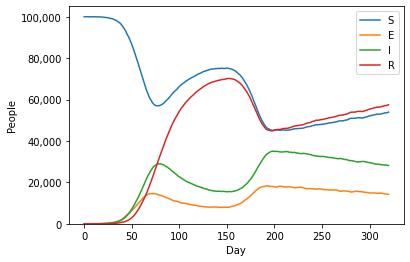

In [ ]:
interv = cv.clip_edges([i for i in range(46,92)], [0.5]*46,layers='w') 
sim3 = cv.Sim(pars, interventions=interv, label='closing workplace by 50%', analyzers=store_seir(label='seir'),
        nab_decay=dict(form='nab_growth_decay', growth_time=10, decay_rate1=0.47, decay_time1=13,decay_rate2=0.13, decay_time2=18)
        , variants=[alpha,beta,gamma3])
sim3.run(verbose=0)
seir = sim3.get_analyzer('seir') # Retrieve by label
seir.plot()

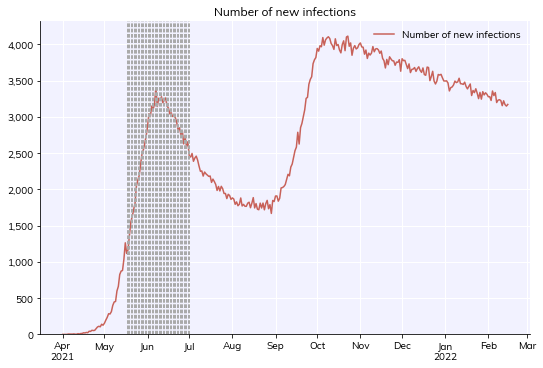

In [ ]:
sim3.plot_result('new_infections')

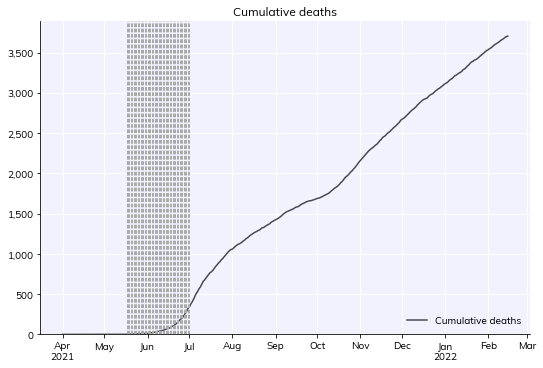

In [ ]:
sim3.plot_result('cum_deaths')

#stage0
* start day : ‘2021-04-01’
* ~ 800 cumalitive deaths till 2021-09-01.
* ~ 100,000 cumalitive infections till 2021-07-01.(every person can get infected).


In [ ]:
sim0 = cv.Sim(pars, label='stage 0', analyzers=store_seir(label='seir'))
sim0.run(verbose=0)

Sim("stage 0"; 2021-04-01 to 2022-02-15; pop: 100000 hybrid; epi: 109749⚙, 762☠)

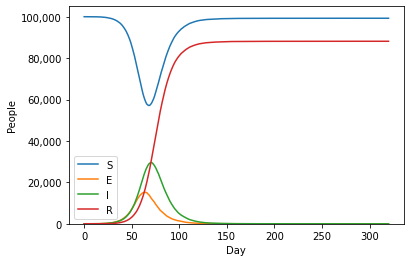

In [ ]:
seir = sim0.get_analyzer('seir') # Retrieve by label
seir.plot()

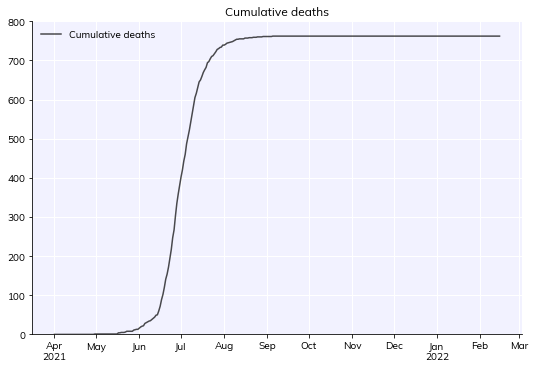

In [ ]:
sim0.plot_result('cum_deaths')

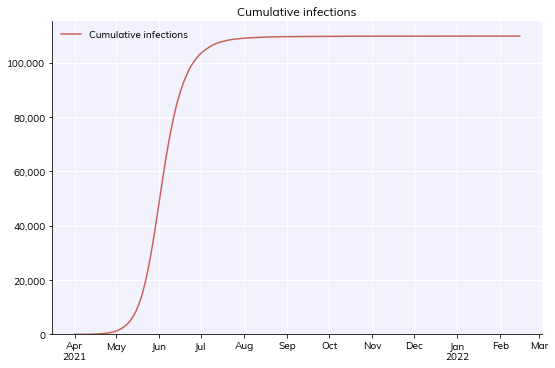

In [ ]:
sim0.plot_result('cum_infections')

# stage 1
* start_day: ‘2021-05-17’, end_day: ‘2021-07-05'.
* cum deaths till end of stage decreased to ~400.
* cum new infections till end of this stage decreased to ~90,000.
* Interventions:
    1. removing mobility by 50% on each day in workplaces from ‘2021-05-17’ till ‘2021-07-01’


In [ ]:
import numpy as np
import pylab as pl
import covasim as cv


interv = cv.clip_edges([i for i in range(46,92)], [0.5]*46,layers='w') # On day 25, reduce overall contacts by 70% to 0.3

sim1 = cv.Sim(pars, interventions=interv, label='closing workplace by 50%',  analyzers=store_seir(label='seir'))
sim1.run(verbose=0)


Sim("closing workplace by 50%"; 2021-04-01 to 2022-02-15; pop: 100000 hybrid; epi: 102251⚙, 746☠)

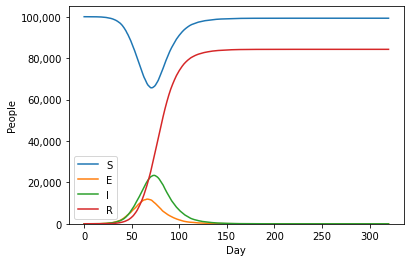

In [ ]:
seir = sim1.get_analyzer('seir') # Retrieve by label
seir.plot()

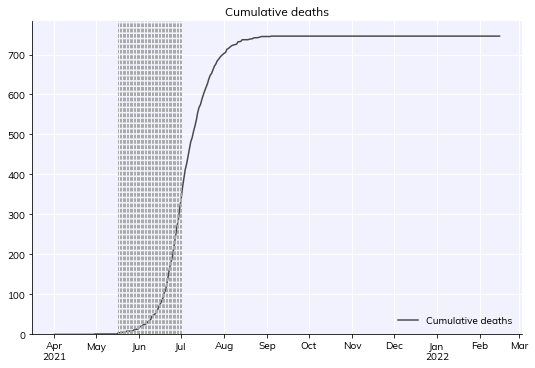

In [ ]:
sim1.plot_result('cum_deaths')

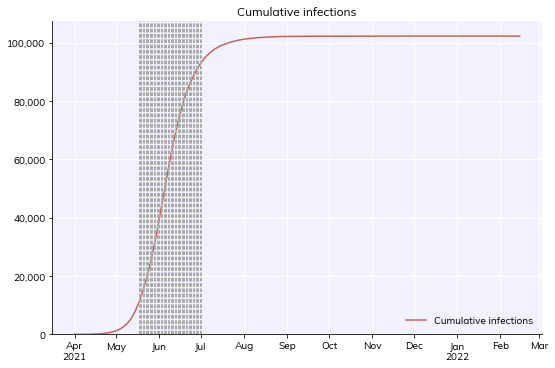

In [ ]:
sim1.plot_result('cum_infections')

#stage 2
* start_day : 2021-07-05, end_day: 2021-09-05.
* cum deaths: ~ 900 by the end of this stage.
* cum new infections: 0 for this stage.
* 3 new variants introduced.
* Interventions:
    1. mandatory use of masks, sanitizers from 2021-07-05 till 2021-09-05 which should reduce the transmition by atleast 5%.
    1. First dose for all, on 10th of july, 20th of july, 30th of july, 9th of august, 19th of august,29th of august with given age priority.This should maake people 80% less prone to get infected and 6% chances of still having symptoms.
    2. Closed schools from 2021-07-05 till 2021-09-05.
    3. work places mobility still locked till 2021-09-05.
    3. testing mandated for people with symptoms(more like to be positive), ~ 500 each day.
    4. 14 days quarantine for positivly diagnoised people.
    5. closing 80 % communities (transports, hotels, day curfew, malls) when the cummulative infections surpasses 500.


In [ ]:
interv = cv.clip_edges([i for i in range(46,158)],[0.5]*112,layers='w')  # removing workplaces from stage 2

#first dose drive by priority
def first_dose_by_age(sim):
    young  = cv.true((sim.people.age < 50) * (sim.people.doses != 0)) # cv.true() returns indices of people matching this condition, i.e. people under 50
    middle = cv.true((sim.people.age >= 50) * (sim.people.age < 75)* (sim.people.doses != 0)) # Multiplication means "and" here
    old    = cv.true((sim.people.age > 75)* (sim.people.doses != 0))
    inds = sim.people.uid # Everyone in the population -- equivalent to np.arange(len(sim.people))
    vals = np.ones(len(sim.people)) # Create the array
    vals[young] = 0.3 # 30% probability for people <50
    vals[middle] = 0.4 # 40% probability for people 50-75
    vals[old] = 0.9 # 90% probability for people >75
    output = dict(inds=inds, vals=vals)
    return output


def inf_thresh(self, sim, thresh=500):
    ''' Dynamically define on and off days for a beta change -- use self like it's a method '''

    # Meets threshold, activate
    if sim.people.infectious.sum() > thresh:
        if not self.active:
            self.active = True
            self.t_on = sim.t

    # Does not meet threshold, deactivate
    else:
        if self.active:
            self.active = False
            self.t_off = sim.t

    return [self.t_on, self.t_off]


on = 0.8 # Beta less than 1 -- intervention is on
off = 1.0 # Beta is 1, i.e. normal -- intervention is off
changes = [on, off]

tn_fixed = cv.test_num(daily_tests=500, start_day='2021-07-05') # since testing for each indiv is not possible
ct = cv.contact_tracing(trace_probs=dict(h=1.0, s=1.0, w=1.0, c=1.0),presumptive=True,quar_period=14)


vaccine1 = cv.simple_vaccine(days=[100,110,120,130,140]
                            , rel_sus=0.8, rel_symp=0.06, subtarget=first_dose_by_age)


close_schools = cv.change_beta(days=[i for i in range(96,158)], changes=[0.9]*62, layers='s') # REMOVING 90 % Schools

close_comm = cv.change_beta(days=inf_thresh, changes=changes, layers='c') #removing 80% communities like hotels,airports
close_comm.t_on = np.nan
close_comm.t_off = np.nan
close_comm.active = False

trans = cv.change_beta(days=[i for i in range(96,158)],changes=[0.05]*62)

sim4 = cv.Sim(pars, interventions=[interv,trans,vaccine1,close_schools,close_comm, tn_fixed,ct], label='stage 2', analyzers=store_seir(label='seir'),
        nab_decay=dict(form='nab_growth_decay', growth_time=10, decay_rate1=0.47, decay_time1=13,decay_rate2=0.13, decay_time2=18)
        , variants=[alpha,beta,gamma3])
sim4.run(verbose=0)


Sim("stage 2"; 2021-04-01 to 2022-02-15; pop: 100000 hybrid; epi: 131329⚙, 960☠)

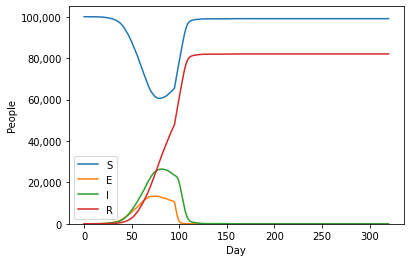

In [ ]:
seir = sim4.get_analyzer('seir') # Retrieve by label
seir.plot()

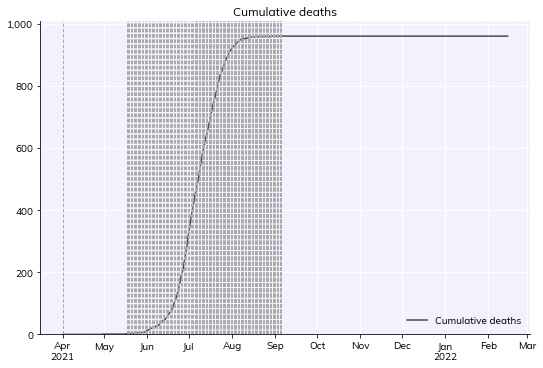

In [ ]:
sim4.plot_result('cum_deaths')


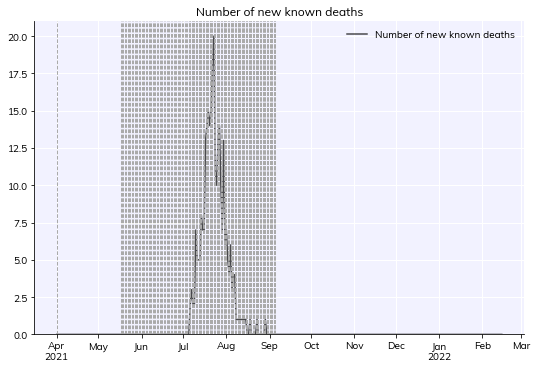

In [ ]:
sim4.plot_result('new_known_deaths')

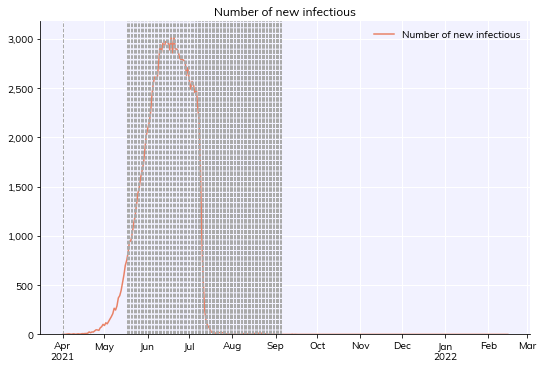

In [ ]:
sim4.plot_result('new_infectious')


# stage 3
* start_day: 2021-09-06.
* end_day: 2021-11-06.

* interventions:
    1. Second drive of vaccine (for first and second dose): on 28th of sep, 8th of oct, 18th of oct.
    2. mask, sanitizers still mandatory till 20th of oct.
    3. school lockdown lifted from 20th of oct.
    4. workplaces lockdown reduced to 10% from 6th of september till 18th of oct then lifted completely..
    4. schools lockdown reduced to 10% from 6th of september till 18th of oct then lifted completely..
    6. dynamic community lockdown lifted completely from 7th of november.
    7. mandatory testing removed from 2021-11-06.



In [ ]:
#second and first dose drive
def first_second_dose_by_age(sim):
    young  = cv.true((sim.people.age < 50) ) # cv.true() returns indices of people matching this condition, i.e. people under 50
    middle = cv.true((sim.people.age >= 50) * (sim.people.age < 75)) # Multiplication means "and" here
    old    = cv.true((sim.people.age > 75))
    inds = sim.people.uid # Everyone in the population -- equivalent to np.arange(len(sim.people))
    vals = np.ones(len(sim.people)) # Create the array
    vals[young] = 0.4 # 10% probability for people <50
    vals[middle] = 0.5 # 50% probability for people 50-75
    vals[old] = 0.9 # 90% probability for people >75
    output = dict(inds=inds, vals=vals)
    return output

#first dose drive by priority
def first_dose_by_age(sim):
    young  = cv.true((sim.people.age < 50) * (sim.people.doses != 0)) # cv.true() returns indices of people matching this condition, i.e. people under 50
    middle = cv.true((sim.people.age >= 50) * (sim.people.age < 75)* (sim.people.doses != 0)) # Multiplication means "and" here
    old    = cv.true((sim.people.age > 75)* (sim.people.doses != 0))
    inds = sim.people.uid # Everyone in the population -- equivalent to np.arange(len(sim.people))
    vals = np.ones(len(sim.people)) # Create the array
    vals[young] = 0.3 # 30% probability for people <50
    vals[middle] = 0.4 # 40% probability for people 50-75
    vals[old] = 0.9 # 90% probability for people >75
    output = dict(inds=inds, vals=vals)
    return output


def inf_thresh(self, sim, thresh=500):
    ''' Dynamically define on and off days for a beta change -- use self like it's a method '''
    if sim.t < 202:
    # Meets threshold, activate
        if sim.people.infectious.sum() > thresh:
            if not self.active:
                self.active = True
                self.t_on = sim.t

        # Does not meet threshold, deactivate
            else:
                if self.active:
                    self.active = False
                    self.t_off = sim.t
        else:
            if self.active:
                self.active = False
                self.t_off = sim.t

    return [self.t_on, self.t_off]


on = 0.8 # Beta less than 1 -- intervention is on
off = 1.0 # Beta is 1, i.e. normal -- intervention is off
changes = [on, off]


interv = cv.clip_edges([i for i in range(46,158)],[0.5]*112,layers='w')  # removing workplaces from stage 2
interv2  = cv.clip_edges([i for i in range(159,202)],changes = [0.1]*43,layers='w')


tn_fixed = cv.test_num(daily_tests=500, start_day='2021-07-05',end_day='2021-11-06') # since testing for each indiv is not possible
ct = cv.contact_tracing(trace_probs=dict(h=1.0, s=1.0, w=1.0, c=1.0),presumptive=True,quar_period=14)


vaccine1 = cv.simple_vaccine(days=[100,110,120,130,140]
                            , rel_sus=0.8, rel_symp=0.06, subtarget=first_dose_by_age)

vaccine2 = cv.simple_vaccine(days=[180,160,170]
                            , rel_sus=0.8, rel_symp=0.06, subtarget=first_second_dose_by_age)


close_schools = cv.change_beta(days=[i for i in range(96,158)], changes=[0.9]*62, layers='s') # REMOVING 90 % Schools
close_schools2 = cv.change_beta(days=[i for i in range(159,202)], changes=[0.1]*43, layers='s') # REMOVING 10 % Schools

close_comm = cv.change_beta(days=inf_thresh, changes=changes, layers='c') #removing 80% communities like hotels,airports
close_comm.t_on = np.nan
close_comm.t_off = np.nan
close_comm.active = False

trans = cv.change_beta(days=[i for i in range(96,202)],changes=[0.05]*106)

sim5 = cv.Sim(pars, interventions=[interv,interv2,trans,vaccine1,vaccine2,close_schools,close_schools2,close_comm, tn_fixed,ct], label='stage 3', analyzers=store_seir(label='seir'),
        nab_decay=dict(form='nab_growth_decay', growth_time=10, decay_rate1=0.47, decay_time1=13,decay_rate2=0.13, decay_time2=18)
        , variants=[alpha,beta,gamma3])
sim5.run(verbose=0)


Sim("stage 3"; 2021-04-01 to 2022-02-15; pop: 100000 hybrid; epi: 139206⚙, 1034☠)

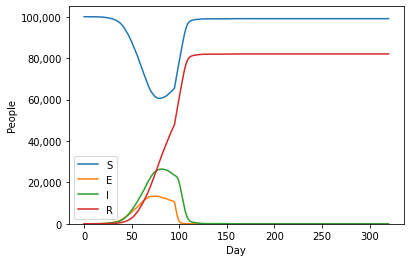

In [ ]:
seir = sim4.get_analyzer('seir') # Retrieve by label
seir.plot()

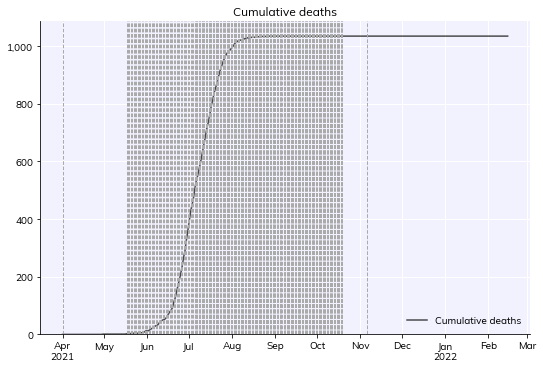

In [ ]:
sim5.plot_result('cum_deaths')

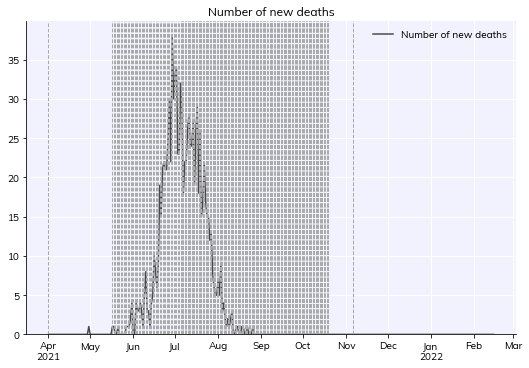

In [ ]:
sim5.plot_result('new_deaths')

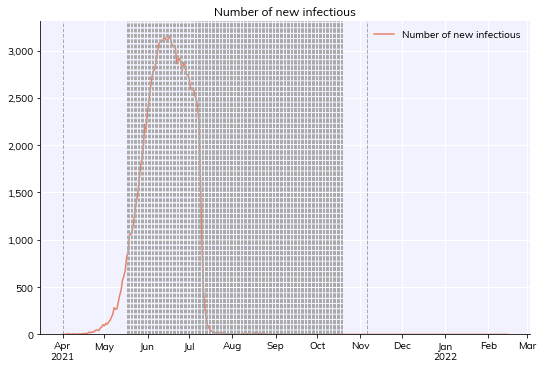

In [ ]:
sim5.plot_result('new_infectious')


Stage 3 ends at 6th of november 2021.


# Final simulation

In [ ]:


sim5

Sim("stage 3"; 2021-04-01 to 2022-02-15; pop: 100000 hybrid; epi: 139206⚙, 1034☠)

# Final comparision

## new infections
1. In Stage 0
2. After Stage 1
3. After Stage 2
4. After Stage 3

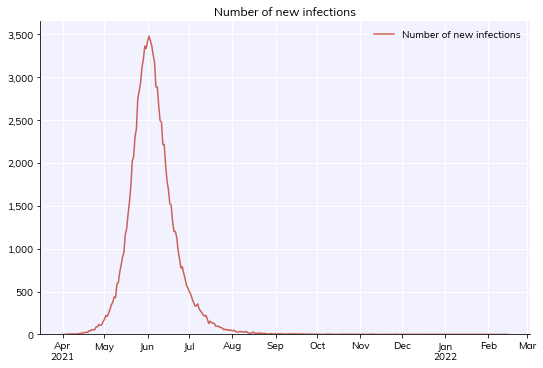

In [ ]:
sim0.plot_result("new_infections")

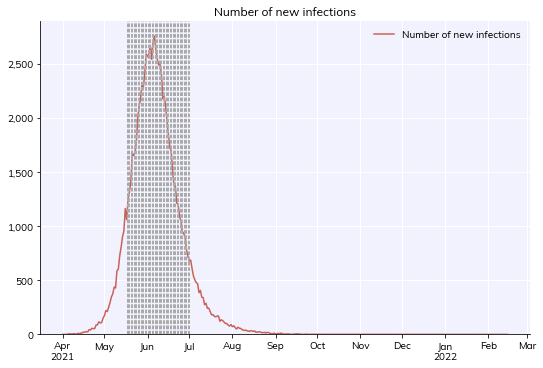

In [ ]:
sim1.plot_result("new_infections")

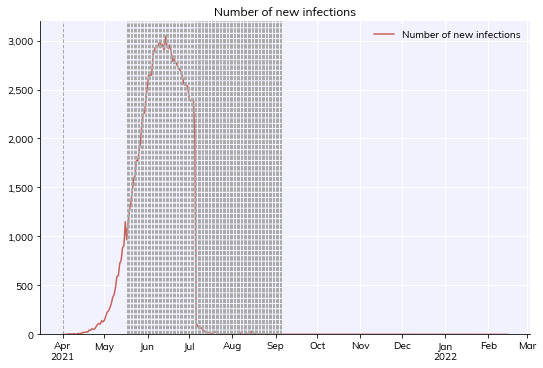

In [ ]:
sim4.plot_result("new_infections")

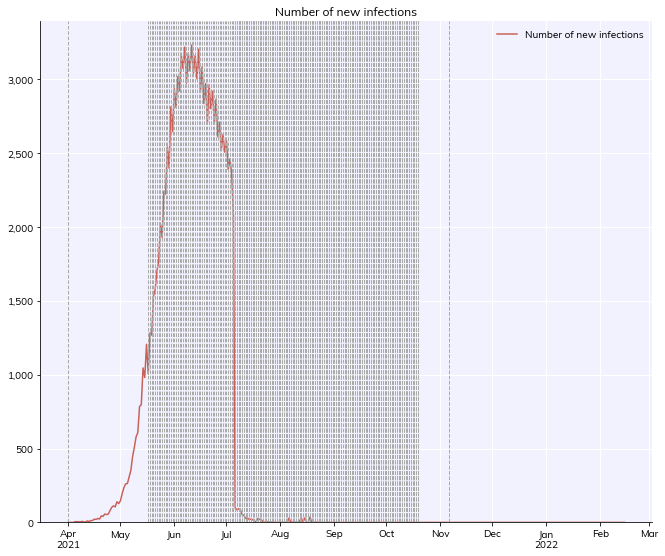

In [ ]:
sim5.plot("new_infections")

## Deaths
1. In Stage 0
2. After Stage 1
3. After Stage 2
4. After Stage 3

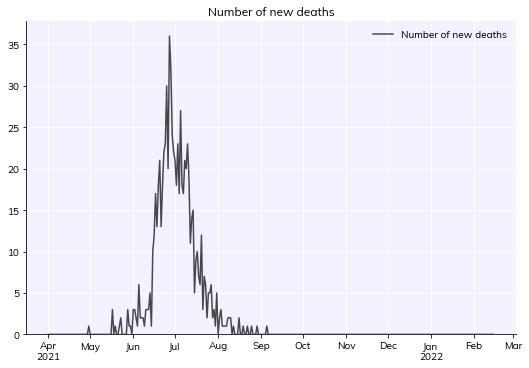

In [ ]:
sim0.plot_result("new_deaths")

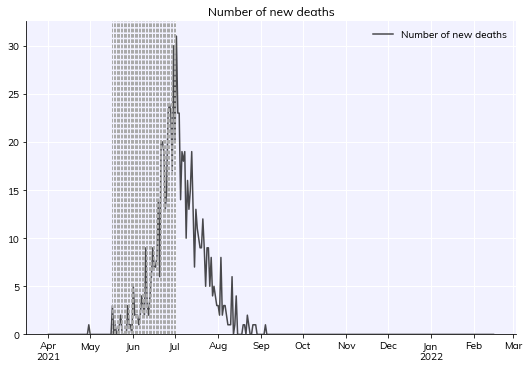

In [ ]:
sim1.plot_result("new_deaths")

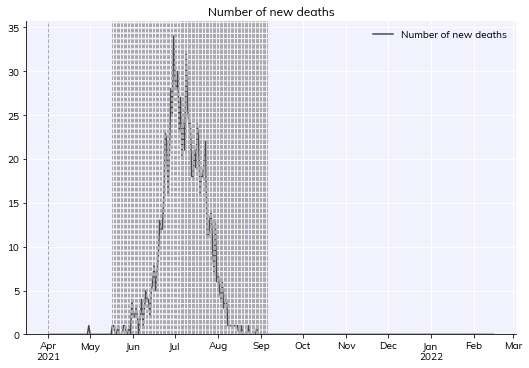

In [ ]:
sim4.plot_result("new_deaths")

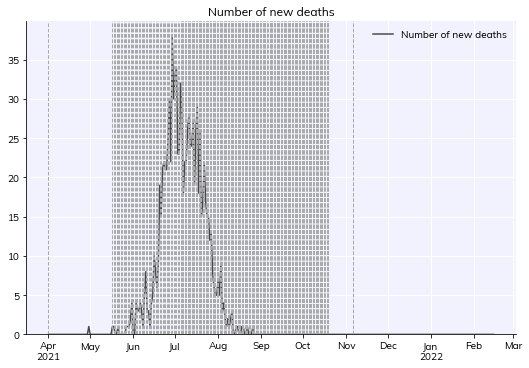

In [ ]:
import matplotlib.pyplot as plt
# plt.title("stage 5")
sim5.plot_result("new_deaths")